## Analysis of tangling across layers (panel E)

In [ ]:
import numpy as np
from functions_notebook import get_layers,measure_tangling
from definitions import ROOT_DIR
import os
import pickle
import umap
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from envs.environment_factory import EnvironmentFactory
import torch
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.vec_env import VecNormalize
from functions_notebook import make_parallel_envs


### A. UMAP
1. __Go to 2. to directly load the previously-obtained data.__\
a. Record trajectories of observations, LSTM, Linear 1, Linear 2 and actions for 3 different masses.\
b. Save the data 

In [ ]:
n_mass = 10
configs = [{
    "weighted_reward_keys": {
        "pos_dist_1": 0,
        "pos_dist_2": 0,
        "act_reg": 0,
        "alive": 0,
        "solved": 5,
        "done": 0,
        "sparse": 0
    },
    "enable_rsi": False,
    "rsi_probability": 0,
    "balls_overlap": False,
    "overlap_probability": 0,
    "noise_fingers": 0,
    "limit_init_angle": 3.141592653589793,
    "goal_time_period": [
        5,
        5
    ],
    "goal_xrange": [
        0.025,
        0.025
    ],
    "goal_yrange": [
        0.027,
        0.027
    ],
    "obj_size_range": [
        0.021,
        0.021
    ],
    "obj_mass_range": [
        mass,
        mass
    ],
    "obj_friction_change": [
        0,
        0,
        0
    ],
    "task_choice": "fixed",
    "rotation_direction" : "cw"
} for mass in np.linspace(0.03,0.3,n_mass)]

PATH_TO_NORMALIZED_ENV = os.path.join(
    ROOT_DIR,
    "trained_models/curriculum_steps_complete_baoding_winner/32_phase_2_smaller_rate_resume/env.pkl",
)
PATH_TO_PRETRAINED_NET = os.path.join(
    ROOT_DIR,
    "trained_models/curriculum_steps_complete_baoding_winner/32_phase_2_smaller_rate_resume/model.zip",
)

env_name = "CustomMyoBaodingBallsP2"

data_list = []
for config in configs : 
    # num_ep = 1 # 1 episode per mass, as the configuration is fixed
    # layers.append(get_layers(config=config,envir=PATH_TO_NORMALIZED_ENV,env_name=env_name,net=PATH_TO_PRETRAINED_NET,num_ep=num_ep))
    render = False

    envs = make_parallel_envs(env_name, config, num_env=1)
    envs = VecNormalize.load(PATH_TO_NORMALIZED_ENV, envs)
    envs.training = False
    envs.norm_reward = False
    custom_objects = {
        "learning_rate": lambda _: 0,
        "lr_schedule": lambda _: 0,
        "clip_range": lambda _: 0,
    }
    model = RecurrentPPO.load(
        PATH_TO_PRETRAINED_NET, env=envs, device="cpu", custom_objects=custom_objects
    )
    eval_env = EnvironmentFactory.create(env_name, **config)   
    lstm_states = (np.zeros((1, 1, 256)), np.zeros((1, 1, 256)))
    cum_rew = 0
    step = 0
    obs = eval_env.reset()
    episode_starts = torch.ones((1,))
    done = False
    while not done:
        lstm_states_tensor = (torch.tensor(lstm_states[0], dtype=torch.float32).reshape(1, -1), torch.tensor(lstm_states[1], dtype=torch.float32).reshape(1, -1))     
        action, lstm_states = model.predict(
            envs.normalize_obs(obs),
            state=lstm_states,
            episode_start=episode_starts,
            deterministic=True,
        )
        with torch.no_grad():
            features = model.policy.extract_features(torch.tensor(envs.normalize_obs(obs)).reshape(1, -1))
            lstm_out, _ = model.policy.lstm_actor(features, (lstm_states_tensor[0] * (1 - episode_starts), lstm_states_tensor[1] * (1 - episode_starts)))
            layer_1_out = model.policy.mlp_extractor.policy_net[1](model.policy.mlp_extractor.policy_net[0](lstm_out))
            layer_2_out = model.policy.mlp_extractor.policy_net[3](model.policy.mlp_extractor.policy_net[2](layer_1_out))
            action_pred = model.policy._get_action_dist_from_latent(layer_2_out).mode().clip(-1, 1)

        assert np.allclose(action_pred, action), print(action_pred, action)
        next_obs, rewards, done, info = eval_env.step(action)
        episode_starts = done
        cum_rew += rewards
        step += 1

        hand_pos = obs[0:23]
        hand_vel = (next_obs[0:23] - hand_pos) / 0.0025
        
        data_point = {
            'time step': step,
            'observation': envs.normalize_obs(obs),
            "lstm_state_0": np.squeeze(lstm_states[0]),
            "lstm_state_1": np.squeeze(lstm_states[1]),
            "lstm_out": np.squeeze(lstm_out.numpy()),
            "layer_1_out": np.squeeze(layer_1_out.numpy()),
            "layer_2_out": np.squeeze(layer_2_out.numpy()),
            "action": action,
            "mass": eval_env.sim.model.body_mass[eval_env.object1_bid],
        }
        data_list.append(data_point)
        obs = next_obs
        
    print("Reward:", cum_rew, "length:", step) 

# mass_episodes_df = pd.DataFrame(data_list)
# mass_episodes_df.to_hdf(os.path.join(ROOT_DIR, "data", "basecamp", "mass_episodes_df.hdf"), key="activations")            


2. Load the trajectories of observations, LSTM, Linear1, Linear2 and actions

In [2]:
# # Load the file from Basecamp : 'layers_mass'
# layers = pickle.load(open('/home/ingster/Bureau/SIL-BigResults/layers_mass','rb'))
# n_mass = 3
df = pd.read_hdf(os.path.join(ROOT_DIR, "data", "basecamp", "mass_episodes_df.hdf"))
df.keys()

Index(['time step', 'observation', 'lstm_state_0', 'lstm_state_1', 'lstm_out',
       'layer_1_out', 'layer_2_out', 'action', 'mass'],
      dtype='object')

In [3]:
n_comp = 8
layer_names = ["observation", "lstm_state_0", "lstm_state_1", "lstm_out", "layer_1_out", "layer_2_out", "action"]
pca = PCA(n_components=n_comp)

for layer in layer_names:
    print("Layer: ", layer)
    data = np.array(df[layer].to_list())
    embeddings = pca.fit_transform(data)
    df[layer + "_pc"] = list(embeddings)

Layer:  observation
Layer:  lstm_state_0
Layer:  lstm_state_1
Layer:  lstm_out
Layer:  layer_1_out
Layer:  layer_2_out
Layer:  action


In [4]:
print(df.keys())

Index(['time step', 'observation', 'lstm_state_0', 'lstm_state_1', 'lstm_out',
       'layer_1_out', 'layer_2_out', 'action', 'mass', 'observation_pc',
       'lstm_state_0_pc', 'lstm_state_1_pc', 'lstm_out_pc', 'layer_1_out_pc',
       'layer_2_out_pc', 'action_pc'],
      dtype='object')


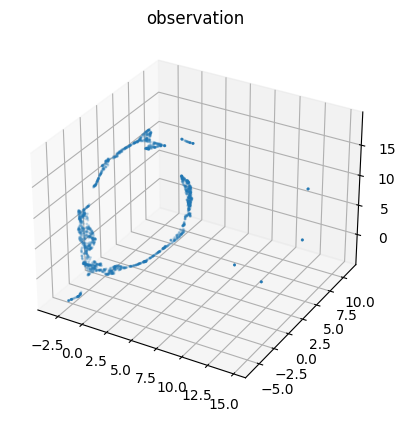

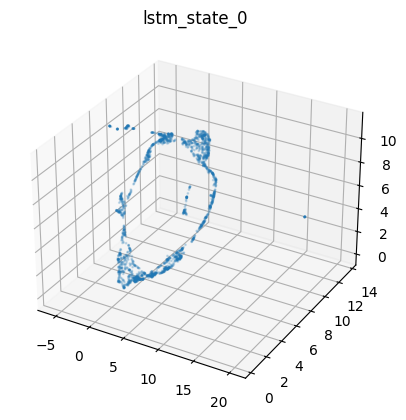

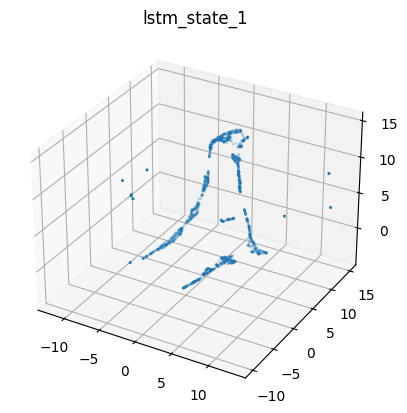

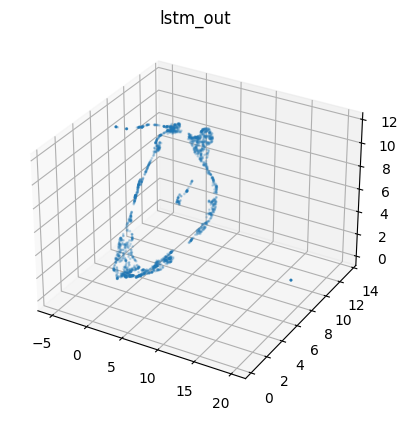

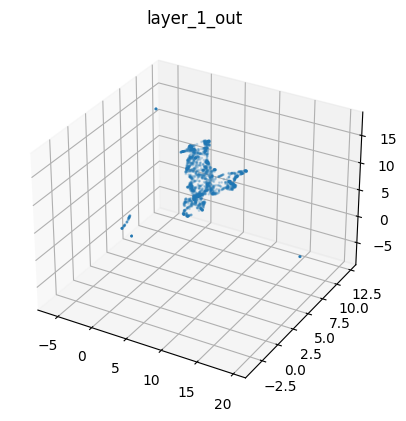

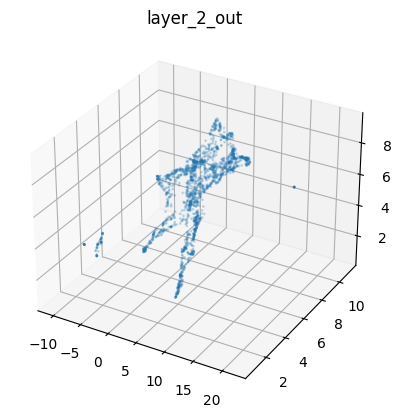

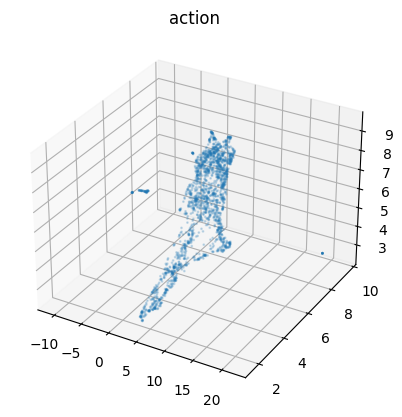

In [19]:
n_comp = 3
reducer = umap.UMAP(n_components=n_comp, random_state=42)

for layer in layer_names:
    data = np.array(df[layer + "_pc"].to_list())
    embeddings = reducer.fit_transform(data)

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], alpha=0.2, s=1)
    plt.title(layer)
    plt.savefig(os.path.join(ROOT_DIR, "data", "figures", "panel_5", f"umap_{layer}_variable_mass.png"), format="png", dpi=600, bbox_inches="tight")
    plt.show()

3. a. Apply UMAP for each layer (+obs, +acts) across masses\
b. Compute the tangling metric per layer and per mass\
c. Compute the global tangling metric per layer (tangling metric averaged over mass and time)

In [ ]:
len_ep1 = len(layers[0])
len_ep2 = len(layers[1])
len_ep3 = len(layers[2])

layers = [item for sublist in layers for item in sublist] # Concatenate all episodes

n_comp = 3
umap_apply = umap.UMAP(n_components=n_comp,random_state=42)

obs = np.array([d['observation'] for d in layers])
obs_trans = umap_apply.fit_transform(obs)
q_obs_ep1 = measure_tangling(obs_trans[0:len_ep1])
q_obs_ep2 = measure_tangling(obs_trans[len_ep1:len_ep1+len_ep2])
q_obs_ep3 = measure_tangling(obs_trans[len_ep1+len_ep2:len_ep1+len_ep2+len_ep3])
Q_obs = np.mean(np.mean(q_obs_ep1)+np.mean(q_obs_ep2)+np.mean(q_obs_ep3))

lstm = np.array([d['LSTM hidden state'] for d in layers])
lstm_trans = umap_apply.fit_transform(lstm)
q_lstm_ep1 = measure_tangling(lstm_trans[0:len_ep1])
q_lstm_ep2 = measure_tangling(lstm_trans[len_ep1:len_ep1+len_ep2])
q_lstm_ep3 = measure_tangling(lstm_trans[len_ep1+len_ep2:len_ep1+len_ep2+len_ep3])
Q_lstm = np.mean(np.mean(q_lstm_ep1)+np.mean(q_lstm_ep2)+np.mean(q_lstm_ep3))

l1 = np.array([d['Linear layer 1'] for d in layers])
l1_trans = umap_apply.fit_transform(l1)
q_l1_ep1 = measure_tangling(l1_trans[0:len_ep1])
q_l1_ep2 = measure_tangling(l1_trans[len_ep1:len_ep1+len_ep2])
q_l1_ep3 = measure_tangling(l1_trans[len_ep1+len_ep2:len_ep1+len_ep2+len_ep3])
Q_l1 = np.mean(np.mean(q_l1_ep1)+np.mean(q_l1_ep2)+np.mean(q_l1_ep3))

l2 = np.array([d['Linear layer 2'] for d in layers])
l2_trans = umap_apply.fit_transform(l2)
q_l2_ep1 = measure_tangling(l2_trans[0:len_ep1])
q_l2_ep2 = measure_tangling(l2_trans[len_ep1:len_ep1+len_ep2])
q_l2_ep3 = measure_tangling(l2_trans[len_ep1+len_ep2:len_ep1+len_ep2+len_ep3])
Q_l2 = np.mean(np.mean(q_l2_ep1)+np.mean(q_l2_ep2)+np.mean(q_l2_ep3))

acts = np.array([d['actions'] for d in layers])
acts_trans = umap_apply.fit_transform(acts)
q_acts_ep1 = measure_tangling(acts_trans[0:len_ep1])
q_acts_ep2 = measure_tangling(acts_trans[len_ep1:len_ep1+len_ep2])
q_acts_ep3 = measure_tangling(acts_trans[len_ep1+len_ep2:len_ep1+len_ep2+len_ep3])
Q_acts = np.mean(np.mean(q_acts_ep1)+np.mean(q_acts_ep2)+np.mean(q_acts_ep3))

4. Plot the projected trajectories

In [ ]:
projected_all = [obs_trans,lstm_trans,l1_trans,l2_trans,acts_trans]
filenames = ['obs','lstm','l1','l2','acts']
titles = ['Observations','LSTM','Linear 1','Linear 2','Actions']
Qs = [Q_obs,Q_lstm,Q_l1,Q_l2,Q_acts]

for projected,filename,title,q in zip(projected_all,filenames,titles,Qs):
    eps = [projected[0:len_ep1],projected[len_ep1:len_ep1+len_ep2],projected[len_ep1+len_ep2:len_ep1+len_ep2+len_ep3]]
    cmap = mpl.colormaps['Set1']
    colors = cmap(np.linspace(0,0.5,n_mass))
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    for i in range(n_mass):
        projected = eps[i]
        ax.plot(projected[:,0],projected[:,1],projected[:,2],color=colors[i],linewidth=1,label='Mass '+str(i+1))

    ax.view_init(elev=30.,azim=45)

    leg = plt.legend(fontsize=21,loc='center left', bbox_to_anchor=(0.7, 0.9))
    for line in leg.get_lines():
        line.set_linewidth(4.0)
    plt.xlabel('Proj. 1',fontsize=21,labelpad=10)
    plt.ylabel('Proj. 2',fontsize=21,labelpad=10)
    ax.set_zlabel('Proj. 3',fontsize=21,labelpad=10)
    plt.title(title,fontsize=21)
    ax.text2D(0.01,0.96, ha='left', va='top', transform=ax.transAxes, s='Q = %s'%np.round(q,3), color='black', 
        bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round',pad=0.3),fontsize=21)
    
    ax.locator_params(axis='x', nbins=5)
    ax.locator_params(axis='y', nbins=5)
    ax.locator_params(axis='z', nbins=5)
    font = {'size': 19}
    plt.xticks(fontsize=font['size'])
    plt.yticks(fontsize=font['size'])
    ax.tick_params('z', labelsize=font['size'])
    plt.show()

5. Plot the tangling metric for each layer (+obs, +acts) through time

In [ ]:
for Qs, title, filename in zip([[q_obs_ep1,q_obs_ep2,q_obs_ep3],[q_lstm_ep1,q_lstm_ep2,q_lstm_ep3],[q_acts_ep1,q_acts_ep2,q_acts_ep3]],['Q Observations','Q LSTM','Q Actions'],['qobs-t','qlstm-t','qacts-t']):
    figure = plt.figure()
    for i in range(len(Qs)) :
        plt.plot(np.arange(0,len(Qs[i]),1),Qs[i],linewidth=1,label='Mass %s'%i,alpha=0.8)
    plt.ylabel(title,fontsize=21)
    plt.xlabel('Time step',fontsize=21)
    plt.xticks(fontsize=19,rotation=45)
    plt.yticks(fontsize=19)
    plt.subplots_adjust(left=0.17,bottom=0.2)
    plt.show()

6. Compare _a_. Q observations with Q actions and _b_. Q LSTM with Q actions, for all the time instances

In [ ]:
obs_trans_per_mass = [obs_trans[0:len_ep1],obs_trans[len_ep1:len_ep1+len_ep2],obs_trans[len_ep1+len_ep2:len_ep1+len_ep2+len_ep3]]
lstm_trans_per_mass = [lstm_trans[0:len_ep1],lstm_trans[len_ep1:len_ep1+len_ep2],lstm_trans[len_ep1+len_ep2:len_ep1+len_ep2+len_ep3]]
acts_trans_per_mass = [acts_trans[0:len_ep1],acts_trans[len_ep1:len_ep1+len_ep2],acts_trans[len_ep1+len_ep2:len_ep1+len_ep2+len_ep3]]

for trans,title,filename in zip([obs_trans_per_mass,lstm_trans_per_mass],['Q observations','Q LSTM'],['obs-acts','lstm-acts']):
    figure = plt.figure()
    for i in range(n_mass):
        plt.scatter(measure_tangling(acts_trans_per_mass[i]),measure_tangling(trans[i]),s=7,label='Mass %s'%i,alpha=0.8)
    plt.ylabel(title,fontsize=21)
    plt.xlabel('Q actions',fontsize=21)
    plt.xticks(fontsize=19)
    plt.yticks(fontsize=19)
    lgnd = plt.legend(fontsize=21,loc='center left', bbox_to_anchor=(0.7, 0.7))
    lgnd.legendHandles[0]._sizes = [40]
    lgnd.legendHandles[1]._sizes = [40]
    lgnd.legendHandles[2]._sizes = [40]
    plt.subplots_adjust(left=0.15,bottom=0.2)
    pt = (0, 0)
    plt.axline(pt, slope=1, color='black')
    plt.axis('square')
    plt.show()

### B. PCA
1. Load trajectories of observations, LSTM, Linear 1, Linear 2 and actions for 3 different masses (same data as in section A)

In [ ]:
# Load the file from Basecamp : 'layers_mass'
layers = pickle.load(open('/home/ingster/Bureau/SIL-BigResults/layers_mass','rb'))
n_mass = 3

3. a. Apply PCA for each layer (+obs, +acts) across masses\
b. Compute the tangling metric per layer and per mass\
c. Compute the global tangling metric per layer (tangling metric averaged over mass and time)\
\
__Remark__. The percentage of explained variance accounted using 25 PCs is :
- 98% for the observations,
- 70% for the LSTM output,
- 87% for the Linear 1 and Linear 2 outputs,
- 94% for the actions.

In [ ]:
len_ep1 = len(layers[0])
len_ep2 = len(layers[1])
len_ep3 = len(layers[2])

layers = [item for sublist in layers for item in sublist] 

n_comp = 25
pca = PCA(n_components=n_comp)

obs = np.array([d['observation'] for d in layers])
obs_trans = pca.fit_transform(obs)
q_obs_ep1 = measure_tangling(obs_trans[0:len_ep1])
q_obs_ep2 = measure_tangling(obs_trans[len_ep1:len_ep1+len_ep2])
q_obs_ep3 = measure_tangling(obs_trans[len_ep1+len_ep2:len_ep1+len_ep2+len_ep3])
Q_obs = np.mean(np.mean(q_obs_ep1)+np.mean(q_obs_ep2)+np.mean(q_obs_ep3))

lstm = np.array([d['LSTM hidden state'] for d in layers])
lstm_trans = pca.fit_transform(lstm)
q_lstm_ep1 = measure_tangling(lstm_trans[0:len_ep1])
q_lstm_ep2 = measure_tangling(lstm_trans[len_ep1:len_ep1+len_ep2])
q_lstm_ep3 = measure_tangling(lstm_trans[len_ep1+len_ep2:len_ep1+len_ep2+len_ep3])
Q_lstm = np.mean(np.mean(q_lstm_ep1)+np.mean(q_lstm_ep2)+np.mean(q_lstm_ep3))

l1 = np.array([d['Linear layer 1'] for d in layers])
l1_trans = pca.fit_transform(l1)

q_l1_ep1 = measure_tangling(l1_trans[0:len_ep1])
q_l1_ep2 = measure_tangling(l1_trans[len_ep1:len_ep1+len_ep2])
q_l1_ep3 = measure_tangling(l1_trans[len_ep1+len_ep2:len_ep1+len_ep2+len_ep3])
Q_l1 = np.mean(np.mean(q_l1_ep1)+np.mean(q_l1_ep2)+np.mean(q_l1_ep3))

l2 = np.array([d['Linear layer 2'] for d in layers])
l2_trans = pca.fit_transform(l2)
q_l2_ep1 = measure_tangling(l2_trans[0:len_ep1])
q_l2_ep2 = measure_tangling(l2_trans[len_ep1:len_ep1+len_ep2])
q_l2_ep3 = measure_tangling(l2_trans[len_ep1+len_ep2:len_ep1+len_ep2+len_ep3])
Q_l2 = np.mean(np.mean(q_l2_ep1)+np.mean(q_l2_ep2)+np.mean(q_l2_ep3))

acts = np.array([d['actions'] for d in layers])
acts_trans = pca.fit_transform(acts)
q_acts_ep1 = measure_tangling(acts_trans[0:len_ep1])
q_acts_ep2 = measure_tangling(acts_trans[len_ep1:len_ep1+len_ep2])
q_acts_ep3 = measure_tangling(acts_trans[len_ep1+len_ep2:len_ep1+len_ep2+len_ep3])
Q_acts = np.mean(np.mean(q_acts_ep1)+np.mean(q_acts_ep2)+np.mean(q_acts_ep3))

4. Plot the tangling metric for each layer (+obs, +acts) through time

In [ ]:
for Qs, title, filename in zip([[q_obs_ep1,q_obs_ep2,q_obs_ep3],[q_lstm_ep1,q_lstm_ep2,q_lstm_ep3],[q_acts_ep1,q_acts_ep2,q_acts_ep3]],['Q Observations','Q LSTM','Q Actions'],['qobs-t','qlstm-t','qacts-t']):
    figure = plt.figure()
    for i in range(len(Qs)) :
        plt.plot(np.arange(0,len(Qs[i]),1),Qs[i],label='Mass %s'%i,linewidth=1,alpha=0.8)
    plt.ylabel(title,fontsize=21)
    plt.xlabel('Time step',fontsize=21)
    plt.xticks(fontsize=19,rotation=45)
    plt.yticks(fontsize=19)
    plt.subplots_adjust(left=0.17,bottom=0.2)
    plt.show()


5. Compare _a_. Q observations with Q actions and _b_. Q LSTM with Q actions, for all the time instances

In [ ]:
obs_trans_per_mass = [obs_trans[0:len_ep1],obs_trans[len_ep1:len_ep1+len_ep2],obs_trans[len_ep1+len_ep2:len_ep1+len_ep2+len_ep3]]
lstm_trans_per_mass = [lstm_trans[0:len_ep1],lstm_trans[len_ep1:len_ep1+len_ep2],lstm_trans[len_ep1+len_ep2:len_ep1+len_ep2+len_ep3]]
acts_trans_per_mass = [acts_trans[0:len_ep1],acts_trans[len_ep1:len_ep1+len_ep2],acts_trans[len_ep1+len_ep2:len_ep1+len_ep2+len_ep3]]

for trans, title,filename in zip([obs_trans_per_mass,lstm_trans_per_mass],['Q observations','Q LSTM'],['obs-acts','lstm-acts']):
    figure = plt.figure()
    for i in range(n_mass):
        plt.scatter(measure_tangling(acts_trans_per_mass[i]),measure_tangling(trans[i]),s=7,label='Mass %s'%i,alpha=0.8)
    plt.ylabel(title,fontsize=21)
    plt.xlabel('Q actions',fontsize=21)
    plt.xticks(fontsize=19)
    plt.yticks(fontsize=19)
    lgnd = plt.legend(fontsize=21,loc='center left', bbox_to_anchor=(0.7, 0.7))
    lgnd.legendHandles[0]._sizes = [40]
    lgnd.legendHandles[1]._sizes = [40]
    lgnd.legendHandles[2]._sizes = [40]
    plt.subplots_adjust(left=0.15,bottom=0.2)
    pt = (0, 0)
    plt.axline(pt, slope=1, color='black')
    plt.axis('square')
    plt.show()

### C. Full space
1. Load trajectories of observations, LSTM, Linear 1, Linear 2 and actions for 3 different masses (same data as in section A and B)

In [ ]:
# Load the file from Basecamp : 'layers_mass'
layers = pickle.load(open('/home/ingster/Bureau/SIL-BigResults/layers_mass','rb'))
n_mass = 3

2. a. Compute the tangling metric per layer and per mass\
b. Compute the global tangling metric per layer (tangling metric averaged over mass and time)\

In [ ]:
obs_ep1 = [d['observation'] for d in layers[0]]
obs_ep2 = [d['observation'] for d in layers[1]]
obs_ep3 = [d['observation'] for d in layers[2]]

q_obs_ep1 = measure_tangling(obs_ep1)
q_obs_ep2 = measure_tangling(obs_ep2)
q_obs_ep3 = measure_tangling(obs_ep3)
Q_obs = np.mean(np.mean(q_obs_ep1)+np.mean(q_obs_ep2)+np.mean(q_obs_ep3))

lstm_ep1 = np.array([d['LSTM hidden state'] for d in layers[0]])
lstm_ep2 = np.array([d['LSTM hidden state'] for d in layers[1]])
lstm_ep3 = np.array([d['LSTM hidden state'] for d in layers[2]])

q_lstm_ep1 = measure_tangling(lstm_ep1)
q_lstm_ep2 = measure_tangling(lstm_ep2)
q_lstm_ep3 = measure_tangling(lstm_ep3)
Q_lstm = np.mean(np.mean(q_lstm_ep1)+np.mean(q_lstm_ep2)+np.mean(q_lstm_ep3))

l1_ep1 = np.array([d['Linear layer 1'] for d in layers[0]])
l1_ep2 = np.array([d['Linear layer 1'] for d in layers[1]])
l1_ep3 = np.array([d['Linear layer 1'] for d in layers[2]])

q_l1_ep1 = measure_tangling(l1_ep1)
q_l1_ep2 = measure_tangling(l1_ep2)
q_l1_ep3 = measure_tangling(l1_ep3)
Q_l1 = np.mean(np.mean(q_l1_ep1)+np.mean(q_l1_ep2)+np.mean(q_l1_ep3))

l2_ep1 = np.array([d['Linear layer 2'] for d in layers[0]])
l2_ep2 = np.array([d['Linear layer 2'] for d in layers[1]])
l2_ep3 = np.array([d['Linear layer 2'] for d in layers[2]])

q_l2_ep1 = measure_tangling(l2_ep1)
q_l2_ep2 = measure_tangling(l2_ep2)
q_l2_ep3 = measure_tangling(l2_ep3)
Q_l2 = np.mean(np.mean(q_l2_ep1)+np.mean(q_l2_ep2)+np.mean(q_l2_ep3))

acts_ep1 = np.array([d['actions'] for d in layers[0]])
acts_ep2 = np.array([d['actions'] for d in layers[1]])
acts_ep3 = np.array([d['actions'] for d in layers[2]])

q_acts_ep1 = measure_tangling(acts_ep1)
q_acts_ep2 = measure_tangling(acts_ep2)
q_acts_ep3 = measure_tangling(acts_ep3)
Q_acts = np.mean(np.mean(q_acts_ep1)+np.mean(q_acts_ep2)+np.mean(q_acts_ep3))

3. Plot the tangling metric for each layer (+obs, +acts) through time

In [ ]:
for Qs, title, filename in zip([[q_obs_ep1,q_obs_ep2,q_obs_ep3],[q_lstm_ep1,q_lstm_ep2,q_lstm_ep3],[q_acts_ep1,q_acts_ep2,q_acts_ep3]],['Q Observations','Q LSTM','Q Actions'],['qobs-t','qlstm-t','qacts-t']):
    figure = plt.figure()
    for i in range(len(Qs)) :
        plt.plot(np.arange(0,len(Qs[i]),1),Qs[i],linewidth=1,label='Mass %s'%i,alpha=0.8)
    plt.ylabel(title,fontsize=21)
    plt.xlabel('Time step',fontsize=21)
    plt.xticks(fontsize=19,rotation=45)
    plt.yticks(fontsize=19)
    plt.subplots_adjust(left=0.17,bottom=0.2)
    plt.show()

4. Compare _a_. Q observations with Q actions and _b_. Q LSTM with Q actions, for all the time instances

In [ ]:
obs_per_mass = [obs_ep1,obs_ep2,obs_ep3]
lstm_per_mass = [lstm_ep1,lstm_ep2,lstm_ep3]
acts_per_mass = [acts_ep1,acts_ep2,acts_ep3]

for trans, title,filename in zip([obs_per_mass,lstm_per_mass],['Q observations','Q LSTM'],['obs-acts','lstm-acts']):
    figure = plt.figure()
    for i in range(n_mass):
        plt.scatter(measure_tangling(acts_per_mass[i]),measure_tangling(trans[i]),s=7,label='Mass %s'%i,alpha=0.8)
    plt.ylabel(title,fontsize=21)
    plt.xlabel('Q actions',fontsize=21)
    plt.xticks(fontsize=19)
    plt.yticks(fontsize=19)
    lgnd = plt.legend(fontsize=21,loc='center left', bbox_to_anchor=(0.7, 0.7))
    lgnd.legendHandles[0]._sizes = [40]
    lgnd.legendHandles[1]._sizes = [40]
    lgnd.legendHandles[2]._sizes = [40]
    plt.subplots_adjust(left=0.15,bottom=0.2)
    pt = (0, 0)
    plt.axline(pt, slope=1, color='black')
    plt.axis('square')
    plt.show()